<a href="https://colab.research.google.com/github/anjali-1002/FFML_Projects_and_Labs/blob/main/FMML_M7_project_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [ ]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-03-15 03:45:01--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.45MB/s    in 0.4s    

2025-03-15 03:45:02 (2.45 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [ ]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [ ]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [ ]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


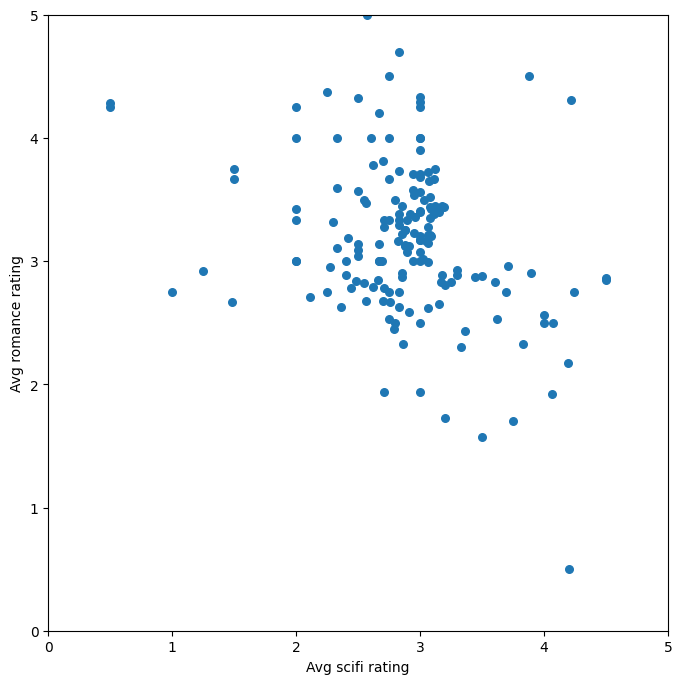

In [ ]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

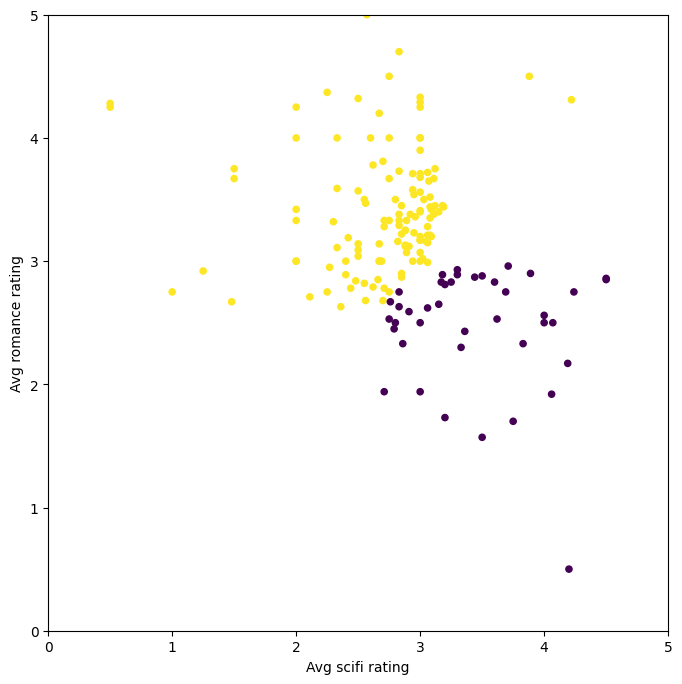

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

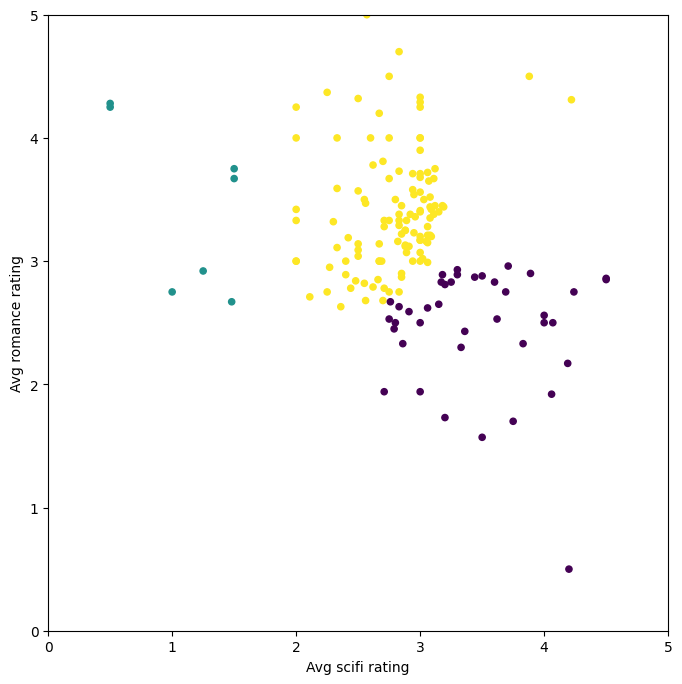

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


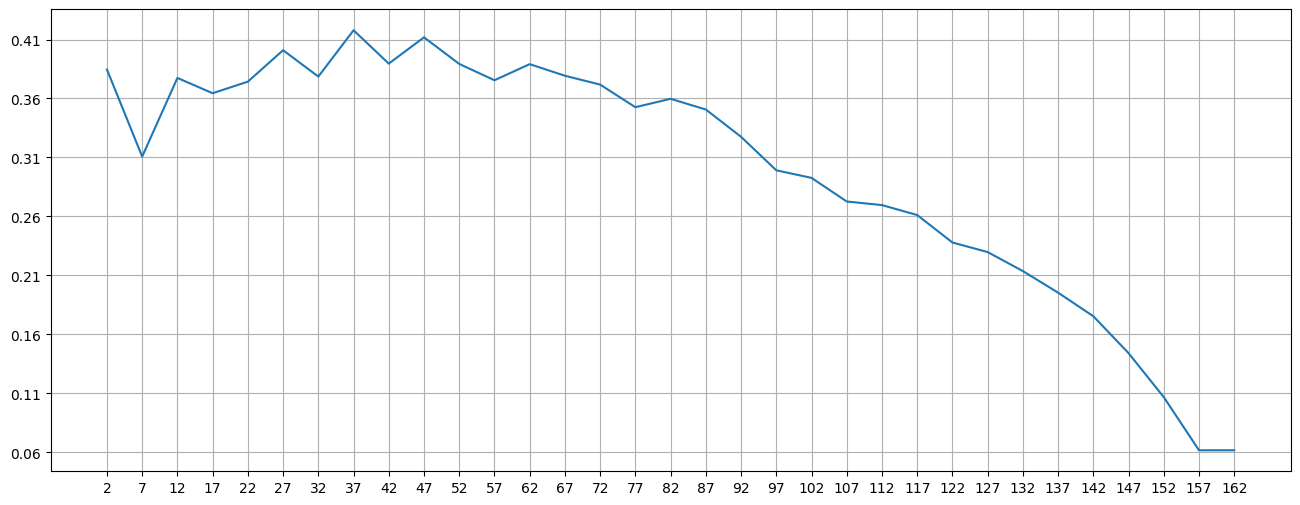

In [ ]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



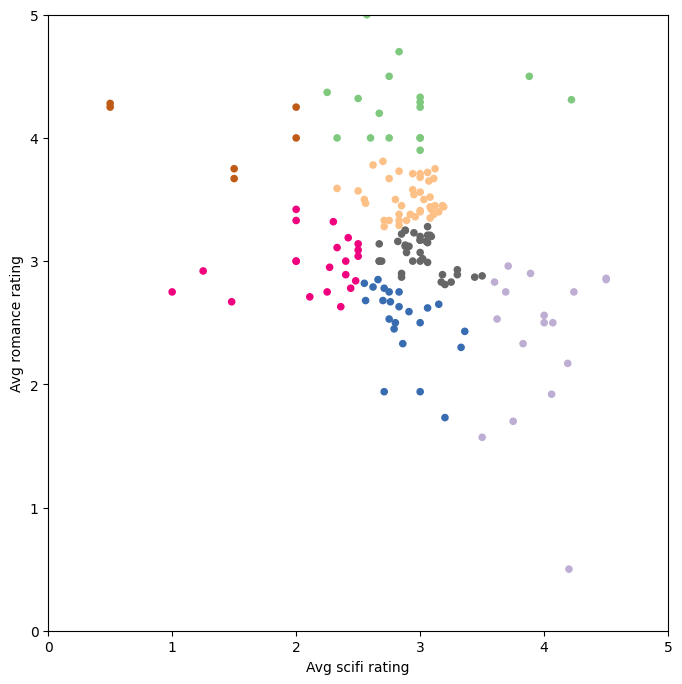

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [ ]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


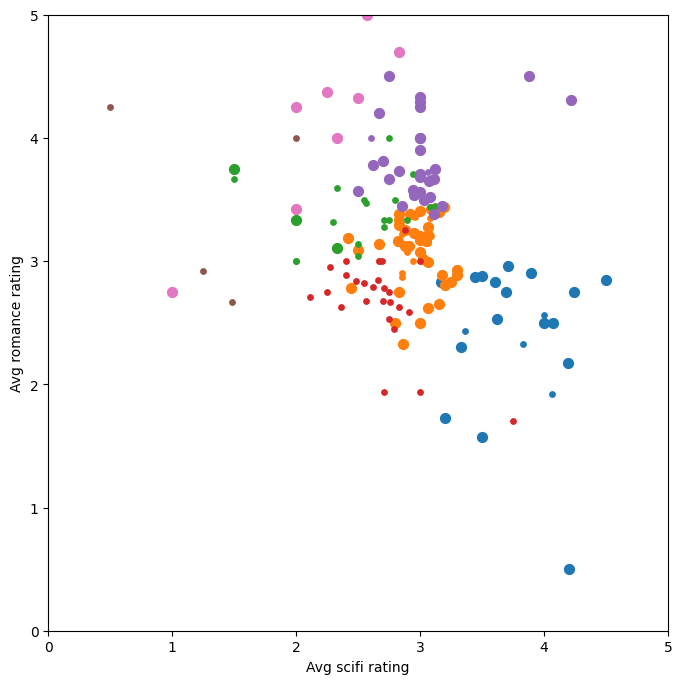

In [ ]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

For n_clusters = 2, the average silhouette score is: 0.4038
For n_clusters = 3, the average silhouette score is: 0.3598
For n_clusters = 4, the average silhouette score is: 0.3343
For n_clusters = 5, the average silhouette score is: 0.3064
For n_clusters = 6, the average silhouette score is: 0.3198
For n_clusters = 7, the average silhouette score is: 0.2975
For n_clusters = 8, the average silhouette score is: 0.3384
For n_clusters = 9, the average silhouette score is: 0.3160
For n_clusters = 10, the average silhouette score is: 0.3416


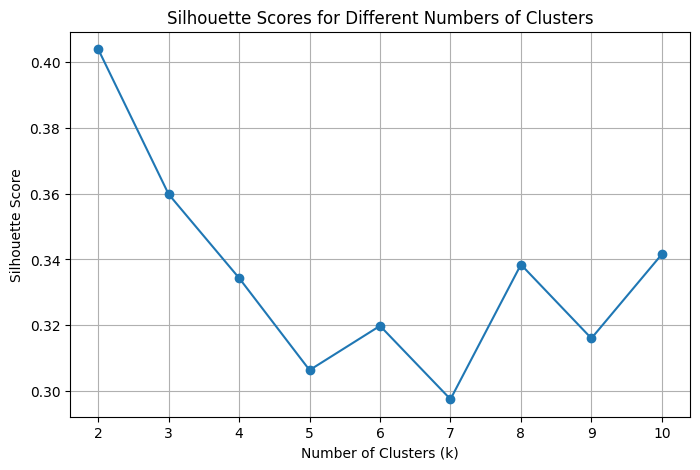

In [ ]:

genre_ratings = genre_ratings.fillna(genre_ratings.mean())

silhouette_scores = []
cluster_range = range(2, 11)  # Trying different k values from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(genre_ratings)
    silhouette_avg = silhouette_score(genre_ratings, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}")

# Plotting silhouette scores for different cluster values
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    count_row = pd.DataFrame([user_movie_ratings.count()], index=['count'])
    user_movie_ratings = pd.concat([user_movie_ratings, count_row], ignore_index=True)
    # 2- Sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings) - 1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- Slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the users who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = -most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('Dataset dimensions:', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions: (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
479                    5.0                               5.0   
473                    3.0                               5.0   
67                     3.5                               3.0   
413                    5.0                               5.0   
589                    5.0                               4.5   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
479                    4.0                               4.5   
473                    4.0                               4.5   
67                     2.0                               3.5   
413                    5.0                               4.0   
589                    4.5                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
479                   5.0                                        4.5   
473                   4.5                                

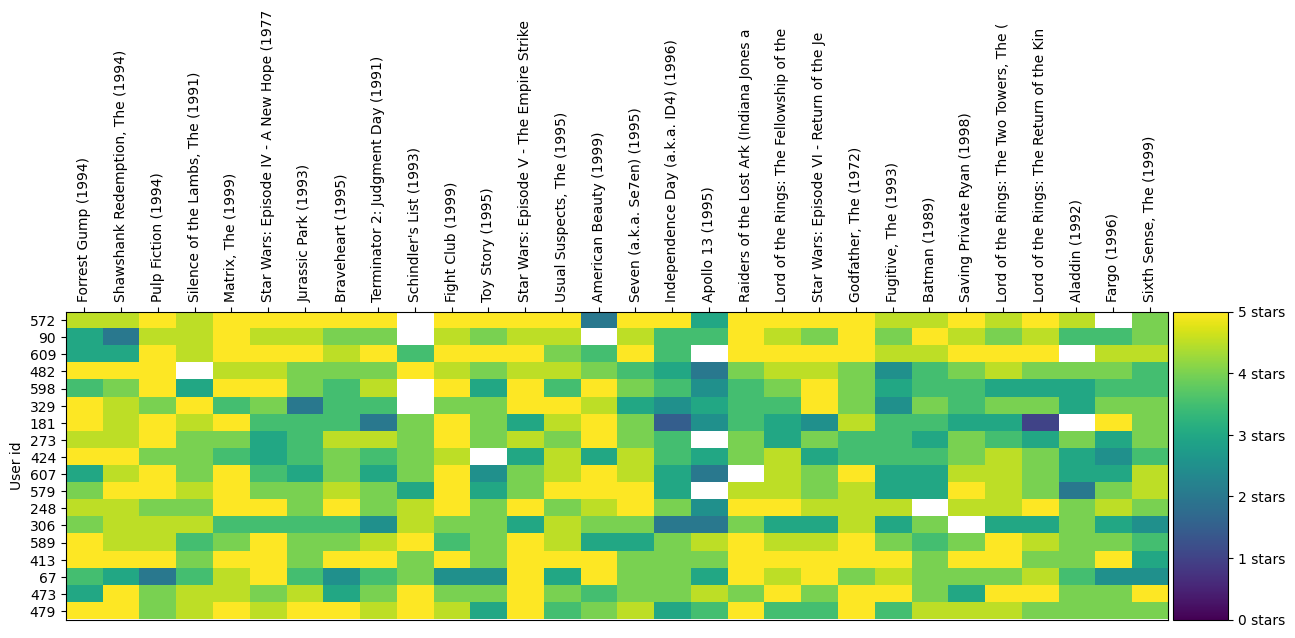

In [ ]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [ ]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [ ]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)

# Select the max number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat(
    [get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group': predictions})],
    axis=1
)

# Optionally print a sample of the clustered data
print(clustered.head())


   index  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0      0                  4.0                               NaN   
1      1                  NaN                               3.0   
2      2                  NaN                               NaN   
3      3                  NaN                               NaN   
4      4                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0                                        5.0  

### Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
18                   2.0                               NaN   
56                   4.0                               NaN   
155                  3.0                               4.5   
198                  2.0                               4.0   
201                  5.0                               4.0   
216                  2.0                               NaN   
220                  3.5                               4.0   
265                  4.0                               NaN   
274                  3.0                               4.0   
289                  NaN                               5.0   
461                  2.5                               4.0   
468                  NaN                               5.0   
554                  5.0                               5.0   
596                  5.0                               NaN   
602                  3.0                               NaN   

     Pu

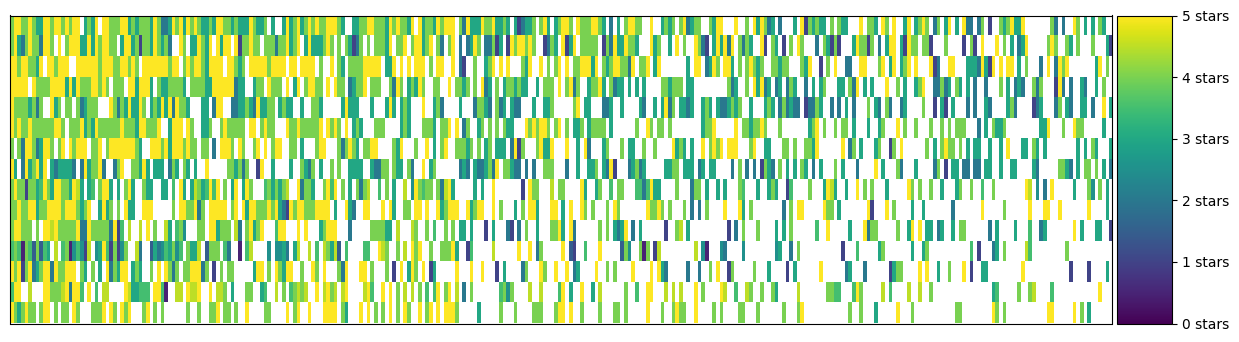

In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

3.8076923076923075

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.400000
L.A. Confidential (1997),4.428571
Blade Runner (1982),4.321429
Shakespeare in Love (1998),3.250000
Star Wars: Episode IV - A New Hope (1977),4.142857
Reservoir Dogs (1992),4.285714
Toy Story (1995),3.807692
Men in Black (a.k.a. MIB) (1997),3.384615
Back to the Future (1985),3.461538
Fargo (1996),4.653846


In [ ]:
cluster

,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),L.A. Confidential (1997),Blade Runner (1982),Shakespeare in Love (1998),Star Wars: Episode IV - A New Hope (1977),Reservoir Dogs (1992),Toy Story (1995),Men in Black (a.k.a. MIB) (1997),Back to the Future (1985),Fargo (1996),...,American Graffiti (1973),Much Ado About Nothing (1993),Star Trek: The Motion Picture (1979),Babe: Pig in the City (1998),"Fly, The (1986)",Air Force One (1997),To Kill a Mockingbird (1962),Star Trek VI: The Undiscovered Country (1991),That Thing You Do! (1996),Gremlins (1984)
11,4.0,5.0,5.0,4.0,4.0,5.0,4.0,3.0,3.0,5.0,...,4.0,NaN,3.0,NaN,3.0,NaN,4.0,3.0,NaN,NaN
14,4.0,5.0,3.0,2.0,4.0,5.0,4.0,4.0,2.0,5.0,...,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,1.0
13,5.0,5.0,4.0,5.0,5.0,4.0,4.0,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,4.0,NaN
1,5.0,5.0,5.0,5.0,5.0,NaN,5.0,4.0,4.0,4.0,...,NaN,3.0,2.0,NaN,NaN,3.0,NaN,4.0,NaN,NaN
0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,2.0,4.0,NaN,...,NaN,3.0,3.0,NaN,2.0,NaN,NaN,5.0,NaN,3.0
4,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
12,4.0,NaN,4.0,2.0,5.0,5.0,4.0,2.0,3.0,5.0,...,3.0,NaN,3.0,NaN,4.0,3.0,NaN,NaN,NaN,3.0
5,5.0,3.0,NaN,2.0,5.0,3.0,4.0,5.0,3.0,5.0,...,3.0,NaN,4.0,4.0,NaN,4.0,NaN,3.0,NaN,2.0
2,4.0,5.0,4.0,4.0,1.0,4.0,4.0,3.0,3.5,5.0,...,NaN,NaN,NaN,4.0,2.5,NaN,4.0,NaN,3.0,NaN
8,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,4.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN


In [ ]:
# Predict for a specific user

# Pick a user ID from the dataset
user_id = 7
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

,0
Citizen Kane (1941),4.900000
Casablanca (1942),4.900000
Hoop Dreams (1994),4.800000
North by Northwest (1959),4.777778
Chinatown (1974),4.777778
Rear Window (1954),4.681818
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.666667
It's a Wonderful Life (1946),4.642857
"Deer Hunter, The (1978)",4.642857
Raging Bull (1980),4.625000


In [ ]:
def predict_ratings_for_user(cluster, user_id, top_n=20):
    # Get all ratings by the specific user
    user_ratings = cluster.loc[user_id, :]

    # Identify movies the user has not rated
    unrated_movies = user_ratings[user_ratings.isnull()]

    # Calculate the average ratings for these movies across all users
    avg_ratings = cluster.mean()

    # Filter the average ratings for the movies the user has not rated
    predicted_ratings = avg_ratings[unrated_movies.index]

    # Sort predicted ratings from highest to lowest
    sorted_predictions = predicted_ratings.sort_values(ascending=False)

    # Display the top N recommendations
    print(f"Top {top_n} movie recommendations for User {user_id}:")
    print(sorted_predictions.head(top_n))

    return sorted_predictions

# Example usage
user_id = 7  # You can change this to any user ID from your dataset
top_n = 20  # Number of top recommendations to display
predicted_ratings = predict_ratings_for_user(clustered, user_id, top_n)


Top 20 movie recommendations for User 7:
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)                                  4.333333
Philadelphia Story, The (1940)                                                 4.310345
Lawrence of Arabia (1962)                                                      4.300000
Hoop Dreams (1994)                                                             4.293103
Godfather, The (1972)                                                          4.289062
Fight Club (1999)                                                              4.272936
Cool Hand Luke (1967)                                                          4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)    4.268041
Rear Window (1954)                                                             4.261905
Godfather: Part II, The (1974)                                                 4.259690
Departed, The (2006)                                                           

## Using Collaborative Filtering (With fast.ai)

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00


In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [ ]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [ ]:
dls.show_batch()

,user,title,rating
0,406,Groundhog Day (1993),3
1,315,Trainspotting (1996),4
2,693,Top Gun (1986),3
3,862,Aliens (1986),5
4,474,"Firm, The (1993)",5
5,896,Clockers (1995),2
6,354,"Fish Called Wanda, A (1988)",3
7,181,"Rich Man's Wife, The (1996)",2
8,709,Highlander (1986),5
9,397,Indiana Jones and the Last Crusade (1989),4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.906176,0.959754,00:08
1,0.696445,0.890687,00:07
2,0.522204,0.871940,00:08
3,0.442722,0.853504,00:08
4,0.436175,0.850820,00:08


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3776),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2865), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2664), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2502), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2420), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2372), 'Airheads (1994)', 2.34375),
 (tensor(-0.2367), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2320),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2305), 'Operation Dumbo Drop (1995)', 2.5161290322580645),
 (tensor(-0.2298), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2294), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2254), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2204), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2146), 'Under Siege 2: Dark Territory (1995)', 2.4583333333333335),
 (tenso

Or the ones with the best bias:

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5964), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5841), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5673), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5210), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5180), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5143), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5072), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4999), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4978), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4977), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4849), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4844), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4576), 'Amadeus (1984)', 4.163043478260869),
 (tensor(0.4530), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4491), 'As Good As It Gets (1997)', 4.196428571428571)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2417), "McHale's Navy (1997)"),
 (tensor(1.1845), 'Leave It to Beaver (1997)'),
 (tensor(1.1718), 'Home Alone 3 (1997)'),
 (tensor(1.1517), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.1314), 'Jungle2Jungle (1997)'),
 (tensor(1.1206), 'Super Mario Bros. (1993)'),
 (tensor(1.0573), 'Bio-Dome (1996)'),
 (tensor(1.0379), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0298), 'Cutthroat Island (1995)'),
 (tensor(1.0251), 'Crow: City of Angels, The (1996)')]

And the worst:

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0909), 'Chinatown (1974)'),
 (tensor(-1.0665), 'Casablanca (1942)'),
 (tensor(-1.0336), 'Close Shave, A (1995)'),
 (tensor(-1.0124), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0082), '12 Angry Men (1957)'),
 (tensor(-1.0028), 'Shall We Dance? (1996)'),
 (tensor(-0.9936), 'Fargo (1996)'),
 (tensor(-0.9722), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9722), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9527), 'When We Were Kings (1996)')]

Same thing for our second dimension:

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1836), 'Braveheart (1995)'),
 (tensor(1.1171), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9962), 'Titanic (1997)'),
 (tensor(0.8918), 'Forrest Gump (1994)'),
 (tensor(0.8542), 'American President, The (1995)'),
 (tensor(0.8542), 'Shawshank Redemption, The (1994)'),
 (tensor(0.8510), 'Independence Day (ID4) (1996)'),
 (tensor(0.8472), "It's a Wonderful Life (1946)"),
 (tensor(0.8240), 'Hunt for Red October, The (1990)'),
 (tensor(0.8030), 'Back to the Future (1985)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9385), 'Stuart Saves His Family (1995)'),
 (tensor(-0.9326), 'Serial Mom (1994)'),
 (tensor(-0.8780), 'Trainspotting (1996)'),
 (tensor(-0.7968), 'Crumb (1994)'),
 (tensor(-0.7708), 'Spanking the Monkey (1994)'),
 (tensor(-0.7662), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7570), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7304), 'Jude (1996)'),
 (tensor(-0.7168), 'Showgirls (1995)'),
 (tensor(-0.7115), 'Cable Guy, The (1996)')]

And we can even plot the movies according to their scores on those dimensions:

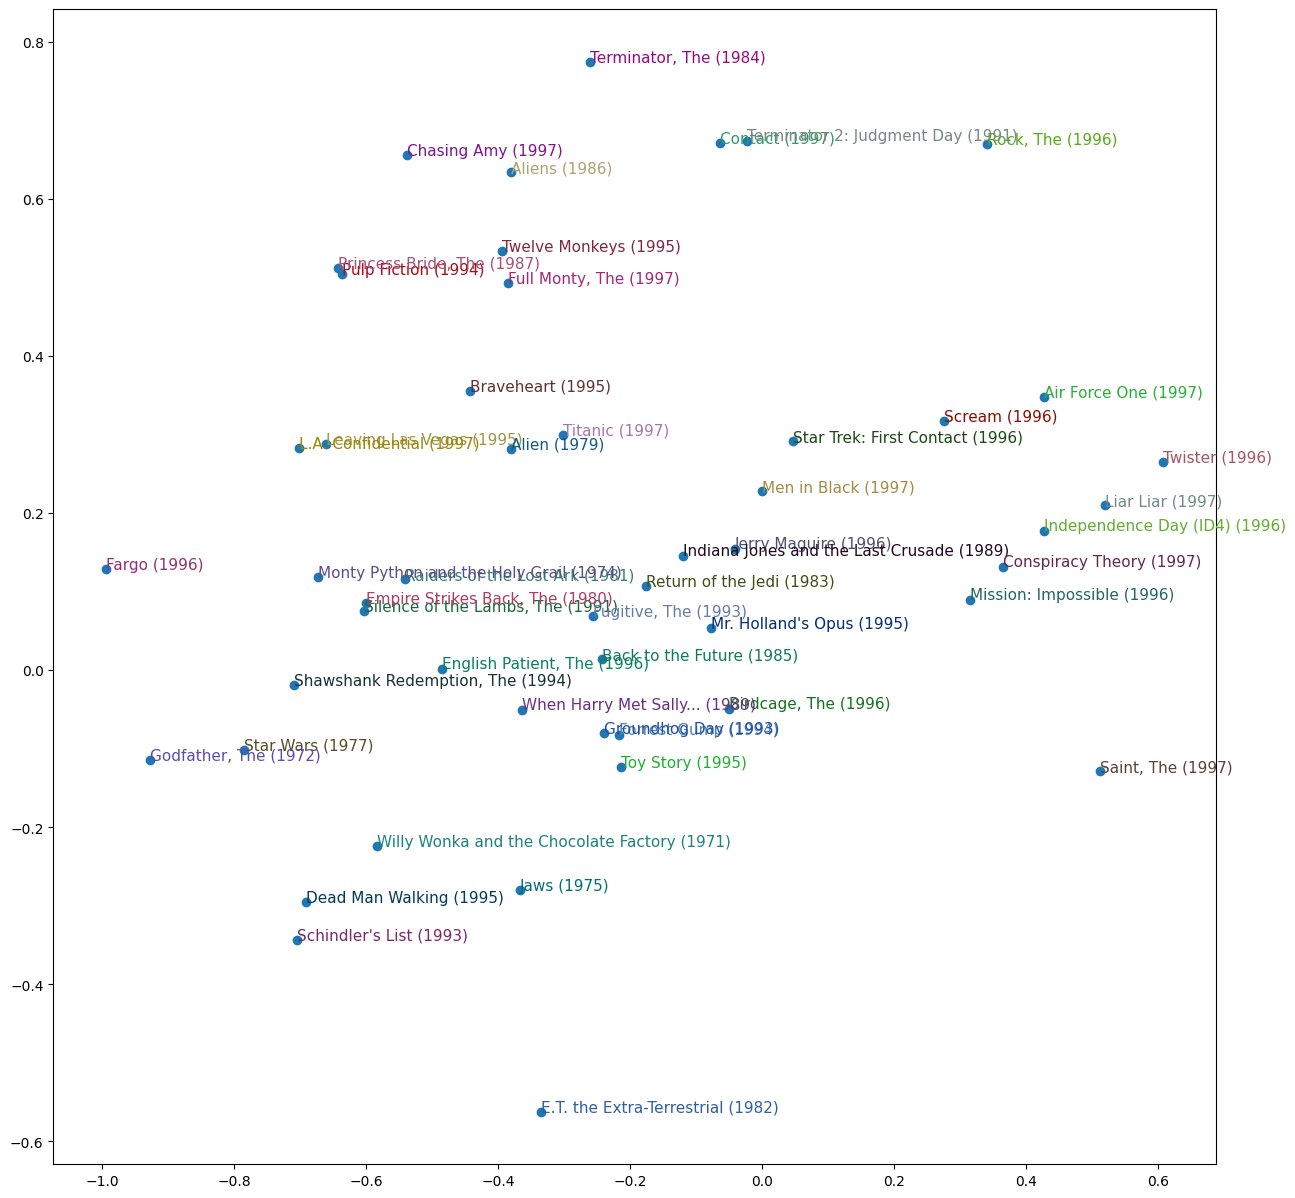

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505189 sha256=45ab7c5574ff4c39b5dc81f7389fb5ac2727989c36c22e2a07e16a804c35bbb3
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
#CODE

# Import necessary libraries
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import time
# Load and transform the data
def load_data(user_movie_ratings):
    # If the index is not numeric (userId), reset the index
    if not isinstance(user_movie_ratings.index, pd.RangeIndex):
        user_movie_ratings = user_movie_ratings.reset_index()

    # Melt the DataFrame to have 'userId', 'movieId', 'rating' columns
    melted_ratings = user_movie_ratings.melt(var_name='movieId', value_name='rating', ignore_index=False)

    # Reset index to move user IDs from index to a column
    melted_ratings = melted_ratings.reset_index().rename(columns={'index': 'userId'})

    # Drop rows with NaN ratings
    melted_ratings = melted_ratings.dropna()

    # Convert userId and movieId to string for compatibility
    melted_ratings['userId'] = melted_ratings['userId'].astype(str)
    melted_ratings['movieId'] = melted_ratings['movieId'].astype(str)

    # Use Surprise's Reader to load the dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(melted_ratings[['userId', 'movieId', 'rating']], reader)
    return data


# Hyperparameter tuning using GridSearchCV
def tune_model(data):
    # Define the parameter grid
    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.02, 0.1]
    }

    # Initialize GridSearchCV with SVD algorithm
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

    # Record the start time
    start_time = time.time()

    # Fit the model and find the best parameters
    gs.fit(data)

    # Calculate the time taken for tuning
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Time taken for hyperparameter tuning: {elapsed_time:.2f} seconds")
    print(f"Best RMSE score: {gs.best_score['rmse']}")
    print(f"Best MAE score: {gs.best_score['mae']}")
    print(f"Best parameters: {gs.best_params['rmse']}")

    return gs.best_estimator['rmse']

# Evaluate the tuned model
def evaluate_model(model, data):
    # Cross-validate the tuned model
    results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    print("Cross-validation results:")
    print(results)

# Load the data
data = load_data(user_movie_ratings)

# Tune the model and get the best estimator
best_model = tune_model(data)

# Evaluate the tuned model
evaluate_model(best_model, data)


Time taken for hyperparameter tuning: 87.77 seconds
Best RMSE score: 27.052702244363086
Best MAE score: 3.063798548921035
Best parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.002, 'reg_all': 0.02}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    27.8398 25.9413 25.5203 25.9954 29.6984 26.9990 1.5689  
MAE (testset)     3.4117  3.0914  2.3834  2.5131  2.9313  2.8662  0.3769  
Fit time          1.96    2.03    2.87    2.05    2.21    2.22    0.33    
Test time         0.10    0.10    0.39    0.10    0.37    0.21    0.14    
Cross-validation results:
{'test_rmse': array([27.83982101, 25.9412741 , 25.52027634, 25.99539776, 29.69844942]), 'test_mae': array([3.41167628, 3.09137957, 2.38337137, 2.51310611, 2.93133007]), 'fit_time': (1.9585459232330322, 2.028308868408203, 2.8660659790039062, 2.0461134910583496, 2.2123043537139893), 'test_time': (0.09548687934875488, 0.0959172248840332, 